# Financial Forecasting Model: Nasdaq 

This notebook will use the Alpaca RESTful API to import 1 minute NASDAQ OHLCV data and train a model to make predictions on stock price behavior.

## Package Imports

### Standard

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

import os

import yaml

import datetime

2025-05-08 15:25:55.199517: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 15:25:55.603956: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 15:25:55.868598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746732356.135242  606384 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746732356.205302  606384 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746732356.760173  606384 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Set matplotlib rcParams

In [69]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12

### Alpaca API Imports

In [4]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit

## Import Authentication Keys

In [5]:
with open("../keys.yaml", "r") as file:
  keys = yaml.safe_load(file)

api_key = keys["api_key"]
secret_key = keys["secret_key"]

## Fetch 1-Minute OHLCV Data

In [6]:
# Tickers to include in data
tickers = ["AAPL", "MSFT", "NVDA", "AMZN", "META", "GOOGL", "GOOG", "AVGO", "COST", "NFLX"]

# Start and end dates of data
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

In [7]:
# Initialize the Alpaca API client
client = StockHistoricalDataClient(api_key, secret_key)

# Create request
request_params = [StockBarsRequest(
  symbol_or_symbols=ticker,
  timeframe=TimeFrame(30, TimeFrameUnit.Minute),
  start=start_date,
  end=end_date,
) for ticker in tickers]

In [25]:
# Fetch data: MEMORY INTENSIVE... ONLY RUN IF SURE
if 1:
  if os.path.isdir(os.getcwd() + "/data"):
    bars_arr = [pd.read_csv("./data/" + file) for file in os.listdir("./data")]
    tickers = [bars_arr[i]["symbol"][0] for i in range(len(bars_arr))]
  else:
    os.mkdir("data")
    i = 0
    bars_arr = [None for _ in tickers]
    for request in request_params:
      print(tickers[i])
      
      bars_arr[i] = client.get_stock_bars(request).df
      bars_arr[i].to_csv(f"data/{tickers[i]}_30min_ohlcv.csv")
      i += 1
  for bar in bars_arr:
    bar["timestamp"] = pd.to_datetime(bar["timestamp"]).dt.tz_convert(None)

## Data Checking and Visualization

In [29]:
# Data shape for each company
print("Shape of Data for Each Company: ")
print([ticker.ljust(12) for ticker in tickers])
print([str(bars_arr[i].shape).ljust(12) for i in range(len(tickers))])
print()
print("Column Names: ")
print(bars_arr[0].columns.values)

Shape of Data for Each Company: 
['AVGO        ', 'MSFT        ', 'COST        ', 'AAPL        ', 'GOOGL       ', 'GOOG        ', 'NVDA        ', 'NFLX        ', 'AMZN        ', 'META        ']
['(14754, 9)  ', '(23334, 9)  ', '(15933, 9)  ', '(23572, 9)  ', '(17491, 9)  ', '(16871, 9)  ', '(22924, 9)  ', '(20214, 9)  ', '(21023, 9)  ', '(23094, 9)  ']

Column Names: 
['symbol' 'timestamp' 'open' 'high' 'low' 'close' 'volume' 'trade_count'
 'vwap']


In [81]:
# Function for plotting
def plot_one_ohlcv(df):
  fig, axes = plt.subplots(1, 2, figsize=(18, 6))
  ax_price = axes[0]
  ax_counts = axes[1]

  fig.suptitle(df["symbol"][0])


  ax_price.set_xlabel("Time")
  ax_price.set_ylabel("Dollars ($)")

  ax_price.set_xticks(pd.date_range(start=df["timestamp"].min(), end=df["timestamp"].max(), freq="6MS"))
  ax_price.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m"))

  ax_price.plot(df["timestamp"], df["open"], label="open", linestyle=":")
  ax_price.plot(df["timestamp"], df["high"], label="high", linestyle=":")
  ax_price.plot(df["timestamp"], df["low"], label="low", linestyle=":")
  ax_price.plot(df["timestamp"], df["close"], label="close", linestyle=":")
  # ax_price.plot(df["timestamp"], df["vwap"], label="vwap", linestyle="--")

  ax_price.grid(True)
  ax_price.legend()


  ax_counts.set_xlabel("Time")
  ax_counts.set_ylabel("Count")

  ax_counts.set_xticks(pd.date_range(start=df["timestamp"].min(), end=df["timestamp"].max(), freq="6MS"))
  ax_counts.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m"))

  ax_counts.plot(df["timestamp"], df["volume"], label="volume", linestyle=":")
  ax_counts.plot(df["timestamp"], df["trade_count"], label="trade_count", linestyle=":")
  ax_counts.set_yscale("log")

  ax_counts.grid(True)
  ax_counts.legend()

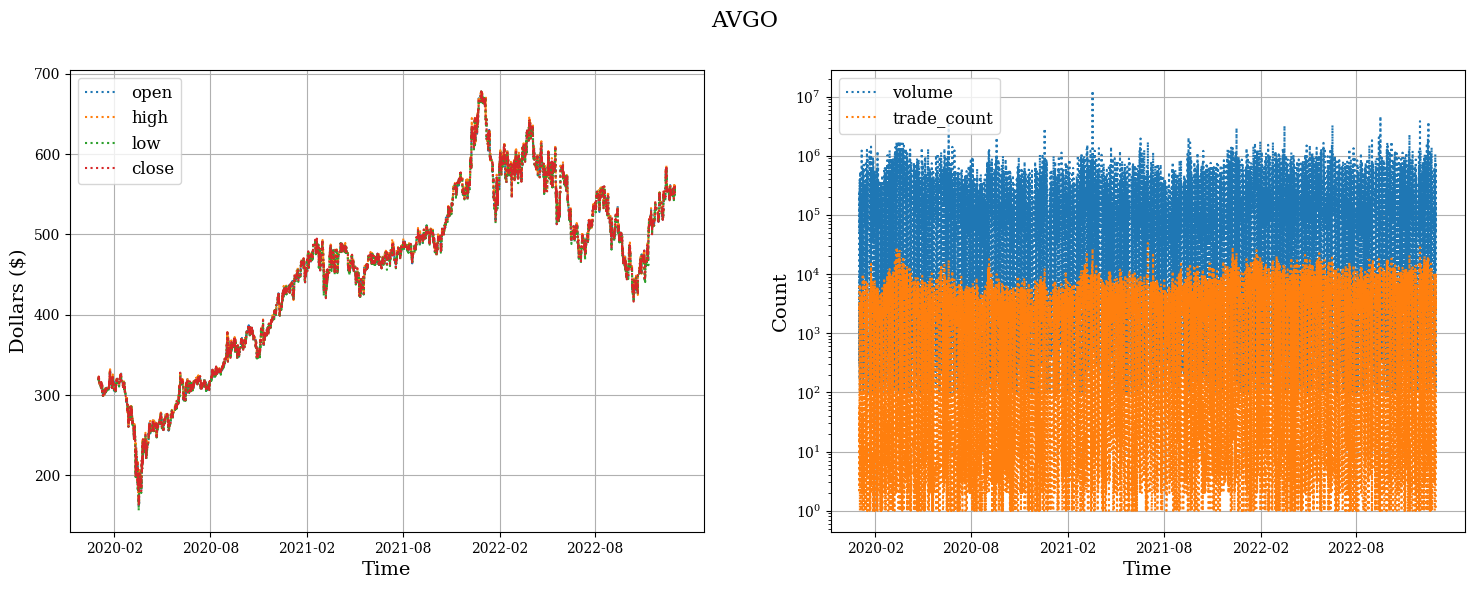

In [82]:
# fig, ax = plot_one_ohlcv(bars_arr[0])
plot_one_ohlcv(bars_arr[0])


In [33]:
# print(bars_arr[0].columns)
# print(bars_arr[0]["close"].values)
# plt.figure()
# plt.plot(bars_arr[3]["open"].values)
# plt.show()
# print(bars_arr[9]["symbol"])

## Pre-Process Data

In [31]:
from sklearn.preprocessing import MinMaxScaler

# TODO: This might not be the correct scaling, because companies are different in size.
features_arr = [bar[["open", "high", "low", "close", "volume"]] for bar in bars_arr]
scaler = MinMaxScaler()
# scaled_data_arr = scaler.fit_transform(features_arr)





# features_arr = [bar[["high"]] for bar in bars_arr]
# print(np.shape(features_arr))


# # Form the input and output structures
# def create_sequences():
  

Try training first just on "high".

## Model Declaration

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [22]:
model = Sequential([
  LSTM(units=50, return_sequences=False, input_shape=()), 
  Dense(1)
])

2025-05-02 17:51:32.060727: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/buck_j/dev/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)

## Model Training

## Model Testing and Evaluation